In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_anharmonic_multinoise as simulate_2d_anharmonic_multinoise

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd

In [2]:
pool = Pool(6)

In [3]:
def get_RSH(A,B,g0,b,ka,th, qc, qw):
    o0 = np.sqrt(-A)
    mu = ka*th / (ka+th)
    den= (o0**2+th**2+g0*mu)**2+b**2*th**2
    
    Sw = qw/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    Sc = qc/g0/2 * (th/ka)**2 / den*( (o0**2+th**2+g0*mu)*(o0**2+ka**2+g0*mu)+b**2*th**2)
    
    Rw = qw/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    Rc = qc/g0/2 * (th/ka)**2 / den*( (o0**2+th**2+g0*mu)*(o0**2+ka**2+g0*mu*(ka/th)**2)+b**2*th**2)
                            
    Hw = - 1/2/g0/ka**2*b
    Hc = qc/g0/2 * (th/ka)**2 / den* b*(ka-th)*(ka+th)
    
    R = Rw+Rc
    S = Sw+Sc
    H = Hw+Hc
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [4]:
# params - A,B,C,D,F,g0,b,ka

params = [
]

# bs =  (0,1,2,3,4,5,6,8,10,12,14,16,18,20,22,24,26,28,30)
bs =  (0,3,8,10,16,20,24,30)
# bs =  (0,3,6,10)#,12,14,16,18,20,22,24,26,28,30)
params += [dict(A=-1,B=0,C=0,D=0,F=0,g0=1,b=b,ka=1, th=1, qw=1, qc=1) for b in bs]
params += [dict(A=2,B=0.14,C=0,D=0,F=0,g0=1,b=b,ka=1, th=1, qw=1, qc=1) for b in bs]
params += [dict(A=2,B=0.14,C=1,D=0.01,F=5,g0=1,b=b,ka=1, th=1, qw=1, qc=1) for b in bs]


df = pd.DataFrame(params)

In [5]:
def f(row):
    return pd.Series(get_RSH(row.A, row.B, row.g0, row.b, row.ka, row.th, row.qc, row.qw),index=("R","S","H","varL"))
df = pd.concat([df, df.apply(f, axis=1)], axis=1, sort=False)

# df["S_init"] = 1/df.g0/2/df.ka**2*(df.ka**2+df.g0*df.ka+df.b**2)

# df["R_init"] = df.A/df.B/2
# df.loc[df.A<0,"R_init"] = 7

# df["H_init"] = - 1/2/df.g0/df.ka**2*df.b

<ipython-input-3-d5ea0ea93ffa>:2: RuntimeWarning: invalid value encountered in sqrt
  o0 = np.sqrt(-A)


In [6]:
df["S_init"] = 0
df["R_init"] = 0
df["H_init"] = 0

In [11]:
N=2000000
warmup=0
dt=0.01
samples=200
skip=1000
runs=6
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [12]:
(len(df) * N * runs * samples *4 // skip) * 4 / 1024**3

0.858306884765625

In [ ]:
results = []
for row in tqdm(df.itertuples(), total=len(df)):
#     if row.Index <40:
#         continue
    kwargs = dict(x0=np.zeros(samples),y0=np.zeros(samples),
                  vx0=np.zeros(samples),vy0=np.zeros(samples),
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        A=row.A,B=row.B,C=row.C,D=row.D,F=row.F,
        gamma0=row.g0,b=row.b, kappa=row.ka, theta=row.th,
        q_white=row.qw, q_colored=row.qc)
    res = simulate_2d_anharmonic_multinoise(pool,runs,**kwargs)
    if dump_to_disk:
        np.save(f"results/{row.Index}", res)
    else:
        results.append(np.array(res[:4], dtype="float32"))

In [10]:
results = np.array(results)

### Load dumped data

In [11]:
import os
n_files = len(os.listdir("results"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'results'

In [ ]:
np.load("results/1.npy").shape

In [ ]:
results = np.zeros((n_files, 4, 800, 5000))

In [ ]:
for i in tqdm(range(n_files)):
    results[i] = np.load(f"results/{i}.npy")[:4,:,-5000:]

In [18]:
results[:,:,:,:].shape

(57, 4, 800, 10000)

### Start Analisys

In [12]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)

In [13]:
cov.shape

(24, 8000, 4, 4)

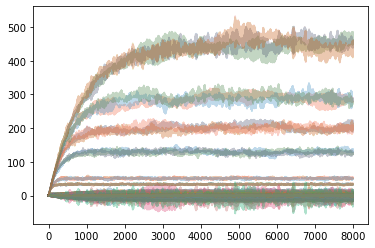

In [14]:
plt.plot(cov.transpose(1,0,2,3).reshape(-1,cov.shape[0]*16)[::], alpha=0.2);
# plt.plot(cov[5,:,1,2]);

In [15]:
stationari_treshold = 5000

In [16]:
results.shape

(24, 4, 1200, 8000)

In [17]:
Rx,Ry, Sx, Sy = results[...,stationari_treshold::10].var(axis=2).transpose(1,0,2)
Lx = results[:,0] * results[:,3]
Ly = results[:,1] * results[:,2]

Hx = Lx.mean(axis=1)
Hy = Ly.mean(axis=1)

In [18]:
df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)
df["Ry"], df["Ry_err"]= mean_with_err(Ry,axis=-1)
df["Sx"], df["Sx_err"]= mean_with_err(Sx,axis=-1)
df["Sy"], df["Sy_err"]= mean_with_err(Sy,axis=-1)
df["Hx"], df["Hx_err"]= mean_with_err(Hx,axis=-1)
df["Hy"], df["Hy_err"]= mean_with_err(Hy,axis=-1)

# df["Rx"], df["Rx_err"]= mean_with_err(Rx,axis=-1)


In [19]:
df[sorted(df.columns)].round(4)

,A,B,C,D,F,H,Hx,Hx_err,Hy,Hy_err,...,Ry_err,S,Sx,Sx_err,Sy,Sy_err,b,g0,ka,varL
0,-1,0.00,0,0.00,0,-0.0,0.0004,0.0004,-0.0007,0.0004,...,0.0022,1.5,1.495900,0.0036,1.494700,0.0036,0,1,1,3.0
1,-1,0.00,0,0.00,0,-1.5,-1.4907,0.0011,1.4905,0.0011,...,0.0023,6.0,5.952800,0.0142,5.947700,0.0141,3,1,1,16.5
2,-1,0.00,0,0.00,0,-4.0,-3.9700,0.0037,3.9707,0.0037,...,0.0024,33.5,33.576900,0.0884,33.495602,0.0870,8,1,1,99.0
3,-1,0.00,0,0.00,0,-5.0,-4.9370,0.0052,4.9373,0.0052,...,0.0024,51.5,51.492802,0.1148,51.391800,0.1111,10,1,1,153.0
4,-1,0.00,0,0.00,0,-8.0,-7.8169,0.0125,7.8181,0.0125,...,0.0025,129.5,129.728699,0.3443,129.804596,0.3512,16,1,1,387.0
5,-1,0.00,0,0.00,0,-10.0,-9.5008,0.0177,9.5024,0.0177,...,0.0023,201.5,204.096298,0.5429,201.004593,0.6108,20,1,1,603.0
6,-1,0.00,0,0.00,0,-12.0,-11.0178,0.0243,11.0206,0.0243,...,0.0020,289.5,288.829987,0.7023,288.896393,0.7142,24,1,1,867.0
7,-1,0.00,0,0.00,0,-15.0,-13.1008,0.0351,13.1070,0.0351,...,0.0019,451.5,442.035187,1.0742,441.909210,1.1038,30,1,1,1353.0
8,2,0.14,0,0.00,0,-0.0,0.0014,0.0010,-0.0015,0.0010,...,0.0094,NaN,1.607700,0.0036,1.606900,0.0038,0,1,1,NaN
9,2,0.14,0,0.00,0,-1.5,-1.4390,0.0020,1.4386,0.0020,...,0.0091,NaN,5.994400,0.0133,5.995200,0.0138,3,1,1,NaN


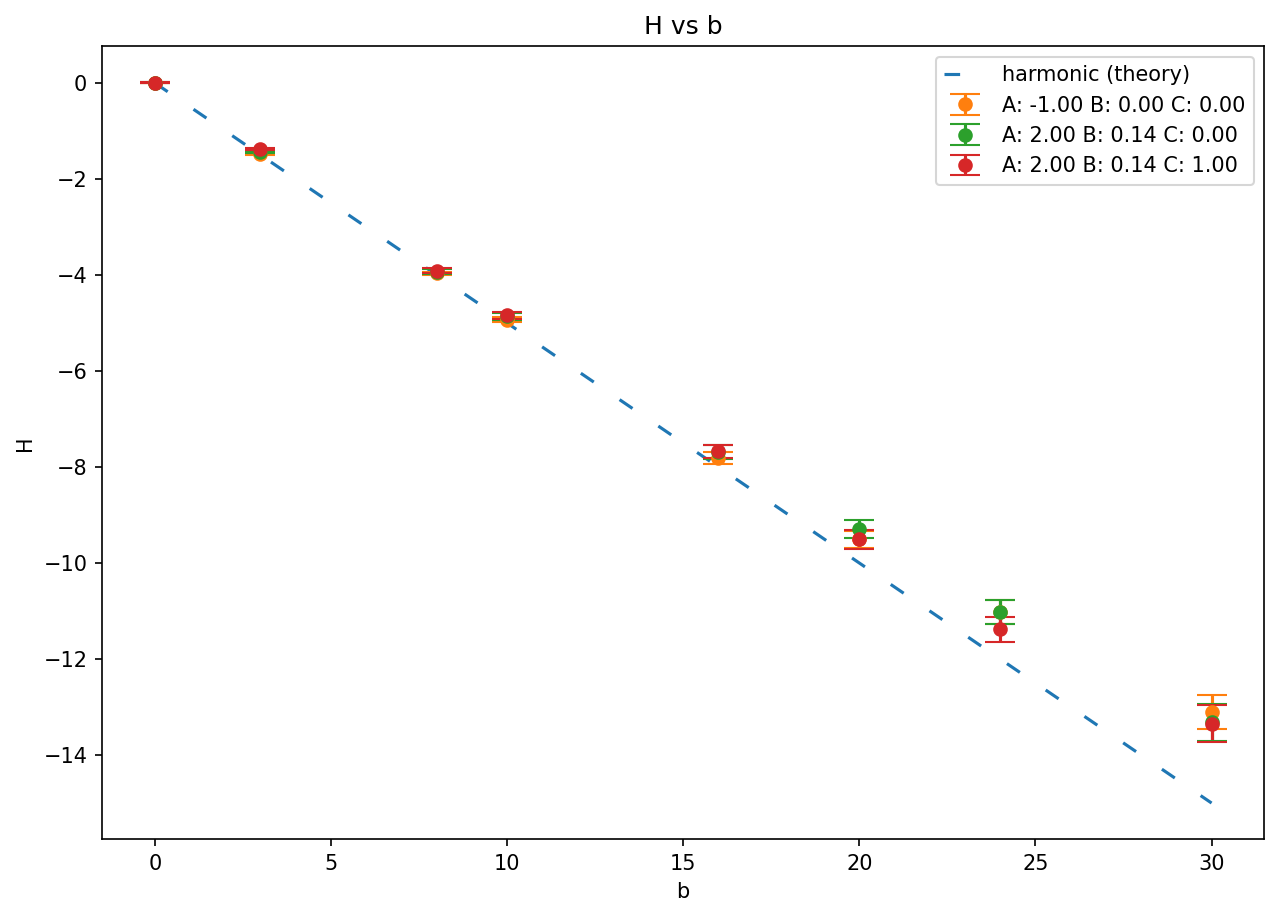

In [20]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.title("H vs b")
plt.xlabel("b");plt.ylabel("H")
plt.plot(*zip(*[(b, get_RSH(-1, 0,1,b,1)[2]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Hx, yerr=gp.Hx_err*10, capsize=7, marker="o", ls="none", 
                 label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
# plt.xlim(-1,5)
# plt.ylim(-4,1)
plt.legend()

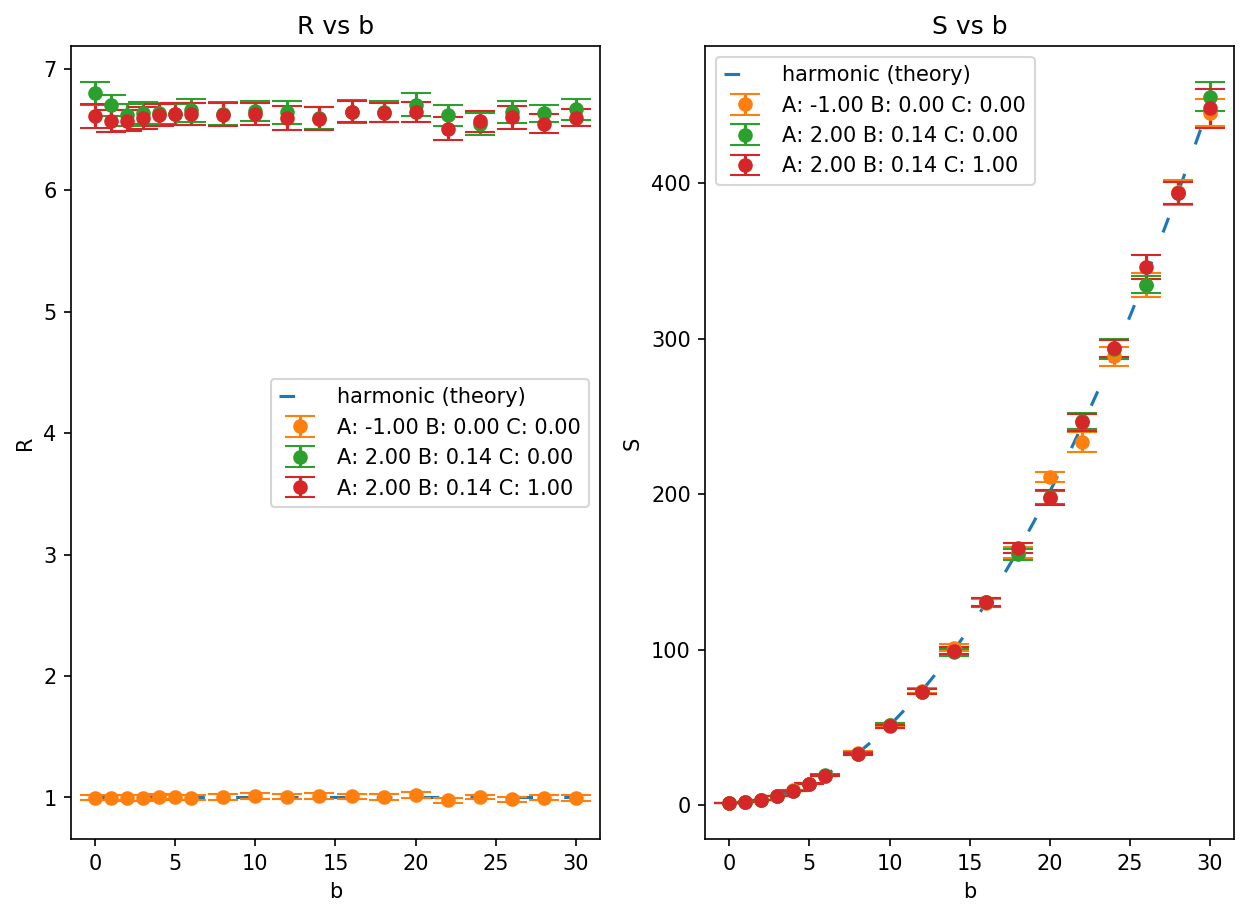

In [39]:
gb=df.groupby(["A","B","C","D","F"])

plt.figure(figsize=(10,7), dpi=150)
plt.subplot(121)
plt.title("R vs b")
plt.xlabel("b");plt.ylabel("R")
plt.plot(*zip(*[(b, get_RSH(-1, 0,1,b,1)[0]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Rx, yerr=gp.Rx_err*10, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

plt.subplot(122)
plt.title("S vs b")
plt.xlabel("b");plt.ylabel("S")
plt.plot(*zip(*[(b, get_RSH(-1, 0,1,b,1)[1]) for b in np.linspace(min(bs), max(bs))]),ls=(0, (5, 10)), label="harmonic (theory)")
for key in gb.groups:
    gp = gb.get_group(key)
#     plt.plot(gp.b, gp.Hx)
    plt.errorbar(gp.b, gp.Sx, yerr=gp.Sx_err*10, capsize=7, marker="o", ls="none", 
                label=f"A: {gp.A.mean():0.2f} B: {gp.B.mean():0.2f} C: {gp.C.mean():0.2f}")
plt.legend()

In [ ]:
gb.groups

In [ ]:
dir(gb)

In [ ]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [ ]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

In [ ]:
H_sample.shape

In [ ]:
H_sample[:,-3000:].mean(axis=1)

In [ ]:
np.sqrt(H_sample[:,-3000:].var(axis=1)/3000)

In [ ]:
H

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [ ]:
results.shape

In [ ]:
L.shape

In [ ]:
# T = results[:,2,:,:]
T = L/2
hlines = H

In [ ]:
T.shape[0]

In [ ]:
fig, axs = plt.subplots(1+T.shape[0]//2,2,figsize=(14,8),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.mean(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")
# plt.show()

In [ ]:
L.shape

In [ ]:
plt.hist(L[0,:,-1], bins=100);

In [ ]:
L[1,:,-1].mean()

In [ ]:
sorted(L[1,:,-1])[1600]

In [ ]:
L.shape

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(L[1,2,3000:])